In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import IPython
import h5py
import decimal
import math
import logging
# from scipy.fftpack import dct

In [2]:
from sputils import sigproc as sp
from sputils import phonedict as phd  # 45 phonemes
# from sputils import phonedictRED as phd  # for reduced phoneme set (38 phonemes) 

In [3]:
dirTrainData = "./TRAINMod"  # the directory of TIMIT train files (.WAV and .PHN)
dirTestData = "./TESTMod"  # the directory of TIMIT test files 

In [4]:
trainfiles = []
for filename in glob.glob(dirTrainData+'/**/*.WAV', recursive=True):
    if filename[-6]!='A': trainfiles.append(filename)  # omit dialects
len(trainfiles)

3696

In [5]:
testfiles = []
for filename in glob.glob(dirTestData+'/**/*.WAV', recursive=True):
    if filename[-6]!='A': testfiles.append(filename)
len(testfiles)

1344

In [6]:
def getCenters(start,step,Nframes):  # calculate frame center samples for each wimdow
    centers = []
    for i in range(Nframes):
        frameCenter = start + i*step
        centers.append(frameCenter)
    return centers

In [7]:
def readPhoneInfo(fl):  # get the labels for all samples
    flnamePHN=fl[:-3]+"PHN"
    flPHN = open(flnamePHN,"r")
    contents = flPHN.readlines()
    flPHN.close()
    return contents

In [8]:
def mapPhone(phon):  # code labelled phonemes numerically according to the dictionary
    if phon[-1].isdigit(): phon=phon[:-2]
    return phd.phn2int.get(phon, phd._pau)

In [9]:
def getPhoneTimes(contents):  # get the end sample number for each phoneme
    pts = {}
    i = 0
    for line in contents:
        lin = line.strip().split()
        phoneme = mapPhone(lin[2])    
        pts[i] =  (int(lin[1]),phoneme)
        i+=1
    return pts

In [10]:
def labelFrames(centers,pts):  # extract the labels corresponding to the window-center samples
    frameLabels = {}
    jmax = len(pts)-1
    j=0
    for i in range(len(centers)):
        if centers[i] > pts[j][0]:
             if j<jmax: j+=1
        frameLabels[i]=pts[j][1]
    return frameLabels  

In [11]:
def getPhoneMids(frameLabels):  # find the middle frame within each phoneme duration
    ich = []
    mids = []
    for i in range(2,Nf):
        if frameLabels[i]!=frameLabels[i-1]: ich.append(i)
    for i in range(len(ich)-1):
        mid = (ich[i+1]+ich[i])//2
        mids.append(mid)
    return mids

In [12]:
lenPic = 14  # even, deliberately two middle values: mid-1 and mid
mid = (lenPic)//2

In [13]:
mid

7

In [14]:
imagesTrn = []
labelsTrn = []
imagesTst = []
labelsTst = []

In [15]:
for fl in trainfiles:
    # print(fl+"\n")
    speech, Fs = sf.read(fl)
    Ns = np.shape(speech)[0]
    step = int(0.01*Fs)
    start = int((0.025/2)*Fs)
    fbank = sp.logfbank(speech,samplerate=Fs,winlen=0.025,winstep=0.01,
          nfilt=40,nfft=512,lowfreq=0,highfreq=None,preemph=0.96)  # 40 filters
    Nf = np.shape(fbank)[0]
    
    centers = getCenters(start,step,Nf)
    
    phoneInfo = readPhoneInfo(fl)
    
    phoneTimes = getPhoneTimes(phoneInfo)
    
    frameLabels = labelFrames(centers,phoneTimes)
    
    phoneMids = getPhoneMids(frameLabels) 
    
    for pm in phoneMids:
        fbnk = fbank[pm-mid:pm+mid]
        if np.shape(fbnk) == (14,40):
            imagesTrn.append(fbank[pm-mid:pm+mid])
            labelsTrn.append(frameLabels[pm])

In [16]:
for fl in testfiles:
    # print(fl+"\n")
    speech, Fs = sf.read(fl)
    Ns = np.shape(speech)[0]
    step = int(0.01*Fs)
    start = int((0.025/2)*Fs)
    fbank = sp.logfbank(speech,samplerate=Fs,winlen=0.025,winstep=0.01,
          nfilt=40,nfft=512,lowfreq=0,highfreq=None,preemph=0.96)  # 40 filters
    Nf = np.shape(fbank)[0]
    
    centers = getCenters(start,step,Nf)
    
    phoneInfo = readPhoneInfo(fl)
    
    phoneTimes = getPhoneTimes(phoneInfo)
    
    frameLabels = labelFrames(centers,phoneTimes)
    
    phoneMids = getPhoneMids(frameLabels) 
    
    for pm in phoneMids:
        fbnk = fbank[pm-mid:pm+mid]
        if np.shape(fbnk) == (14,40):
            imagesTst.append(fbank[pm-mid:pm+mid])
            labelsTst.append(frameLabels[pm])

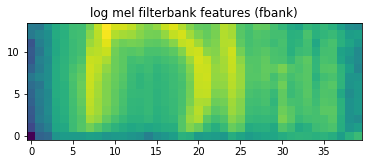

In [25]:
plt.imshow(imagesTrn[1], interpolation="nearest", origin="lower")
plt.title('log mel filterbank features (fbank)')
plt.show()

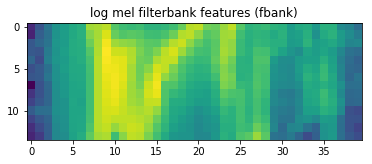

In [26]:
plt.imshow(imagesTrn[2], interpolation="nearest")
plt.title('log mel filterbank features (fbank)')
plt.show()

In [27]:
np.shape(imagesTrn)

(121583, 14, 40)

In [28]:
np.shape(labelsTrn)

(121583,)

In [29]:
np.shape(imagesTst)

(44125, 14, 40)

In [30]:
np.shape(labelsTst)

(44125,)

In [31]:
imagesTrn = np.array(imagesTrn, dtype=np.float32)
imagesTst = np.array(imagesTst, dtype=np.float32)

In [32]:
labelsTrn = np.array(labelsTrn, dtype=np.int8)
labelsTst = np.array(labelsTst, dtype=np.int8)

## Store the calculated features & labels

In [37]:
with h5py.File("timitdata.hdf5", "w") as timitfeatures:
    timitfeatures.create_dataset("imagesTrn", (121583, 14, 40), data=imagesTrn)
    timitfeatures.create_dataset("labelsTrn", (121583,) , data=labelsTrn)
    timitfeatures.create_dataset("imagesTst", (44125, 14, 40), data=imagesTst)
    timitfeatures.create_dataset("labelsTst", (44125,) , data=labelsTst)
timitfeatures.close()



In [38]:
dfl = h5py.File("timitdata.hdf5", "r")


In [39]:
dfl["labelsTst"]

<HDF5 dataset "labelsTst": shape (44125,), type "|i1">

In [40]:
dfl.close()